In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import model_selection, preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
import sklearn.metrics as sklm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
color = sns.color_palette()



In [46]:
# change wd and import data files
os.chdir("/Users/hubertjenq/kaggle/sberbank russian housing")
train_df = pd.read_csv("train.csv",parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv",parse_dates=['timestamp'])
VIFvalues=pd.read_csv("VIFvalues.csv")

#use only macroeconomic columns from the macro data
macroecon_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]



macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macroecon_cols)

#Convert timestamp to year, month, day of week, and date 
train_df['yearsale']=pd.DatetimeIndex(train_df['timestamp']).year
train_df['monthsale']=pd.DatetimeIndex(train_df['timestamp']).month
train_df['dayofweeksale']=pd.DatetimeIndex(train_df['timestamp']).weekday
train_df['dateofsale']=pd.DatetimeIndex(train_df['timestamp']).day

#make material an object type
train_df['material']=train_df['material'].astype(object)

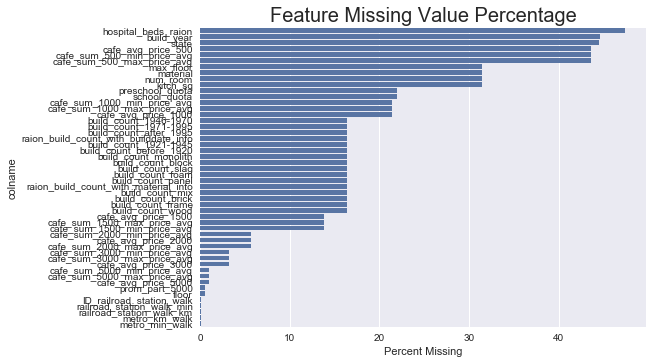

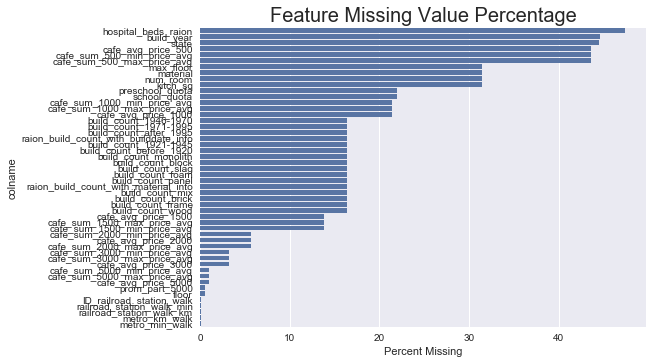

In [49]:
navalues=train_df.isnull().sum(axis=0).reset_index()
navalues.columns=['colname','number_missing']
missingvalues=navalues.loc[navalues['number_missing']>0]
sortedmissingvaldf=missingvalues.sort_values('number_missing',ascending=False)
index=missingvalues.shape[0]


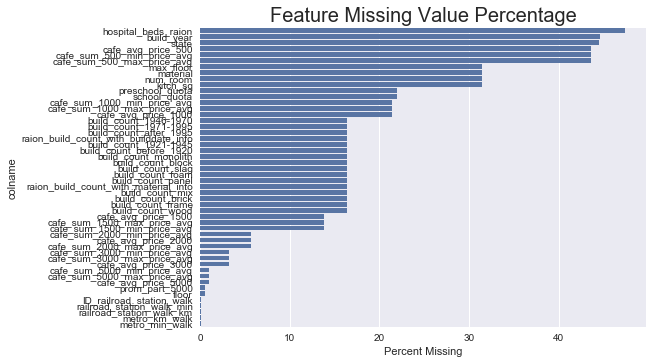

In [50]:
fig= plt.figure()
sns.barplot(sortedmissingvaldf.number_missing/train_df.shape[0]*100,sortedmissingvaldf.colname,color=color[0])
plt.xlabel('Percent Missing')
plt.title('Feature Missing Value Percentage', fontsize=20)
plt.tight_layout
plt.savefig('navals.png',dpi=300)
plt.show()

In [1]:
fig=plt.figure()

ax1=fig.add_subplot(221)
sns.distplot(train_df.price_doc.values, bins=50,kde=False)
ax2=fig.add_subplot(222)
sns.distplot(train_df.full_sq.values, bins=200,kde=False)
plt.xlim(0,500)
ax3=fig.add_subplot(223)
sns.countplot(train_df.floor.values)
ax4=fig.add_subplot(224)
sns.distplot(train_df.num_room.dropna().values, bins=50,kde=False)
plt.xlim(0,10)
ax1.set_xlabel('$')
ax1.set_title('House Price')

ax2.set_xlabel('Housing square footage.')
ax2.set_title('Square Meters')

plt.tight_layout()
plt.show()

train_df['yearmonth']=100*train_df['yearsale']+train_df['monthsale']
grouped_priceyear=train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()
fig=plt.figure()
sns.barplot(grouped_priceyear.yearmonth.values,grouped_priceyear.price_doc,color=color[0])
plt.xticks(rotation='vertical')
plt.xlabel('Year-month')
plt.ylabel('Median house price')
plt.title('Median house price by year-month', fontsize=20)
plt.savefig('medianhouseprice.png',dpi=300)

train_df=pd.read_csv("train.csv",parse_dates=['timestamp'])
dtype_df=train_df.dtypes.reset_index()
dtype_df.columns=["count","coltype"]
dtype_df.groupby("coltype").aggregate('count').head(n=100)


#Find number of NA's
navalues=train_df.isnull().sum(axis=0).reset_index()
navalues.columns=['colname','number_missing']
missingvalues=navalues.loc[navalues['number_missing']>0]
sortedmissingvaldf=missingvalues.sort_values('number_missing',ascending=False)
index=missingvalues.shape[0]
fig= plt.figure()
sns.barplot(sortedmissingvaldf.number_missing/train_df.shape[0]*100,sortedmissingvaldf.colname,color=color[0])
plt.xlabel('Percent Missing')
plt.title('Feature Missing Value Percentage', fontsize=20)
plt.tight_layout
plt.savefig('navals.png',dpi=300)

internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']
corrmat = train_df[internal_chars].corr()
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
plt.title('Correlation Matrix for House Characteristics', fontsize=20)
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)
plt.savefig('corrmat.png',dpi=300)

missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
index = np.arange(missing_df.shape[0])
width = 0.9
missing_df.head()

train_df=pd.read_csv("train.csv",parse_dates=['timestamp'])
catlabels=pd.DataFrame()
for f in train_df.columns:
    if train_df[f].dtype=='object':
        label=preprocessing.LabelEncoder() 
        label.fit(list(train_df[f].values))
        catlabels[f]=label.transform(list(train_df[f].values))
        train_df[f]=label.transform(list(train_df[f].values))
catlabels.head()

train_y = np.log1p(train_df.price_doc.values)
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)


xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features 
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

importance = model.get_fscore()
VariableImpDf=pd.DataFrame(list(importance.items()),columns=['Variable','Fscore'])
SortedVIDf=VariableImpDf.sort_values('Fscore',ascending=False)

fig=plt.figure()
numfeatures=25
sns.barplot(SortedVIDf.Fscore[0:numfeatures],SortedVIDf.Variable[0:numfeatures],color=color[0])
plt.tight_layout()
plt.savefig('featimp.png',dpi=300)
plt.show()
#force the outliers to be equal to the .5% and 99.5% percentile respectively so the
#plot is easier to read.

ulimit = np.percentile(train_df.price_doc.values, 100)
llimit = np.percentile(train_df.price_doc.values, 0)
train_df['price_doc'].loc[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].loc[train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 100)
llimit = np.percentile(train_df[col].values, 0)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10,kind='kde')
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square meters', fontsize=12)
plt.title('Log Price Vs. Log Total Area', fontsize=20)
plt.savefig('logpricevsarea.png',dpi=300)
plt.show()

col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df[col]), y=np.log1p(train_df['price_doc']), size=10,kind="kde")
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Life area in square meters', fontsize=12)
plt.title('Log Price Vs. Log Life Area', fontsize=20)
plt.show()

plt.figure(figsize=(12,8))
FloorPricedf=train_df.groupby('num_room').agg({'price_doc':'median'}).reset_index()
sns.pointplot(FloorPricedf['floor'],FloorPricedf['price_doc'],color=color[0])
plt.xticks(rotation='vertical')
plt.ylabel('Median Price')
plt.title('Median Price by Floor', fontsize=20)
plt.savefig('pricebyfloor.png',dpi=300)


plt.figure(figsize=(12,8))
sns.boxplot(x="build_year", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Build Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Median Price by Build Year', fontsize=20)
plt.savefig('medpricebybuildyear.png',dpi=300)

plt.show()

NameError: name 'plt' is not defined